# Introduction to Recommender Systems

<p align="center">
    <img width="721" alt="cover-image" src="https://user-images.githubusercontent.com/49638680/204351915-373011d3-75ac-4e21-a6df-99cd1c552f2c.png">
</p>

---

# The Exercise

In this exercise, you will implement a simple recommender system using the GoodRead dataset. The dataset contains information about books, authors, and user ratings. The goal is to recommend books to users based on their ratings.

## The Dataset

The dataset is available at this link: [GoodReads Dataset](https://github.com/zygmuntz/goodbooks-10k/releases/download/v1.0/goodbooks-10k.zip). It contains the following files:

- `books.csv`: Contains information about books.
- `ratings.csv`: Contains user ratings for books.
- `book_tags.csv`: Contains tags assigned to books.

## The Task

You need to implement a simple recommender system that recommends books to users based on their ratings.

### Steps

1. Download the dataset.
2. Perfom data analysis.
3. Justify all the choices you make as results of some data analysis.
4. Implement the recommender system.

### Tasks

While implementing the recommender system, you need to perform the following tasks (that are also a guideline for the implementation).

#### Data Analysis

- Load and explore the dataset.
- Analyse the distribution of ratings.
- Visualise the number of ratings per book and per user.
- Check for missing values and decide how to handle them.


#### Feature Engineering

- Encode User_ID and Book_Title as integer indices for the model.
- Create a feature to represent the popularity of books based on the number of ratings.
- Optionally, incorporate author information if it improves the model.

#### Building the Recommender System

- Split the data into training and test sets.
- Implement a collaborative filtering model using matrix factorization.
- Train the model and evaluate its performance using RMSE (Root Mean Square Error) on the test set.
- Generate book recommendations for a set of users.- 

#### Recommendations

- Write a function to display the top N recommended books for a given user.
- Discuss how different features and the size of the dataset affect the model's performance.

In [1]:
# Import libraries
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
plt.style.use('seaborn-whitegrid')
plt.rcParams["figure.figsize"] = (20, 13)
%matplotlib inline
%config InlineBackend.figure_format = "retina"

## Import the dataset

The only file you need to import is `ratings.csv`. The other files are optional and can be used to improve the model.

In [2]:
df_ratings = pd.read_csv("../../data/goodbooks-10k/ratings.csv")
df_ratings

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3
...,...,...,...
5976474,49925,510,5
5976475,49925,528,4
5976476,49925,722,4
5976477,49925,949,5


## Data Analysis

Let's start by performing some data analysis.

First of all, we want to see the distribution of ratings.

/opt/homebrew/lib/python3.11/site-packages/seaborn/_core.py:1218: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_core.py:1218: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_core.py:1218: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releas

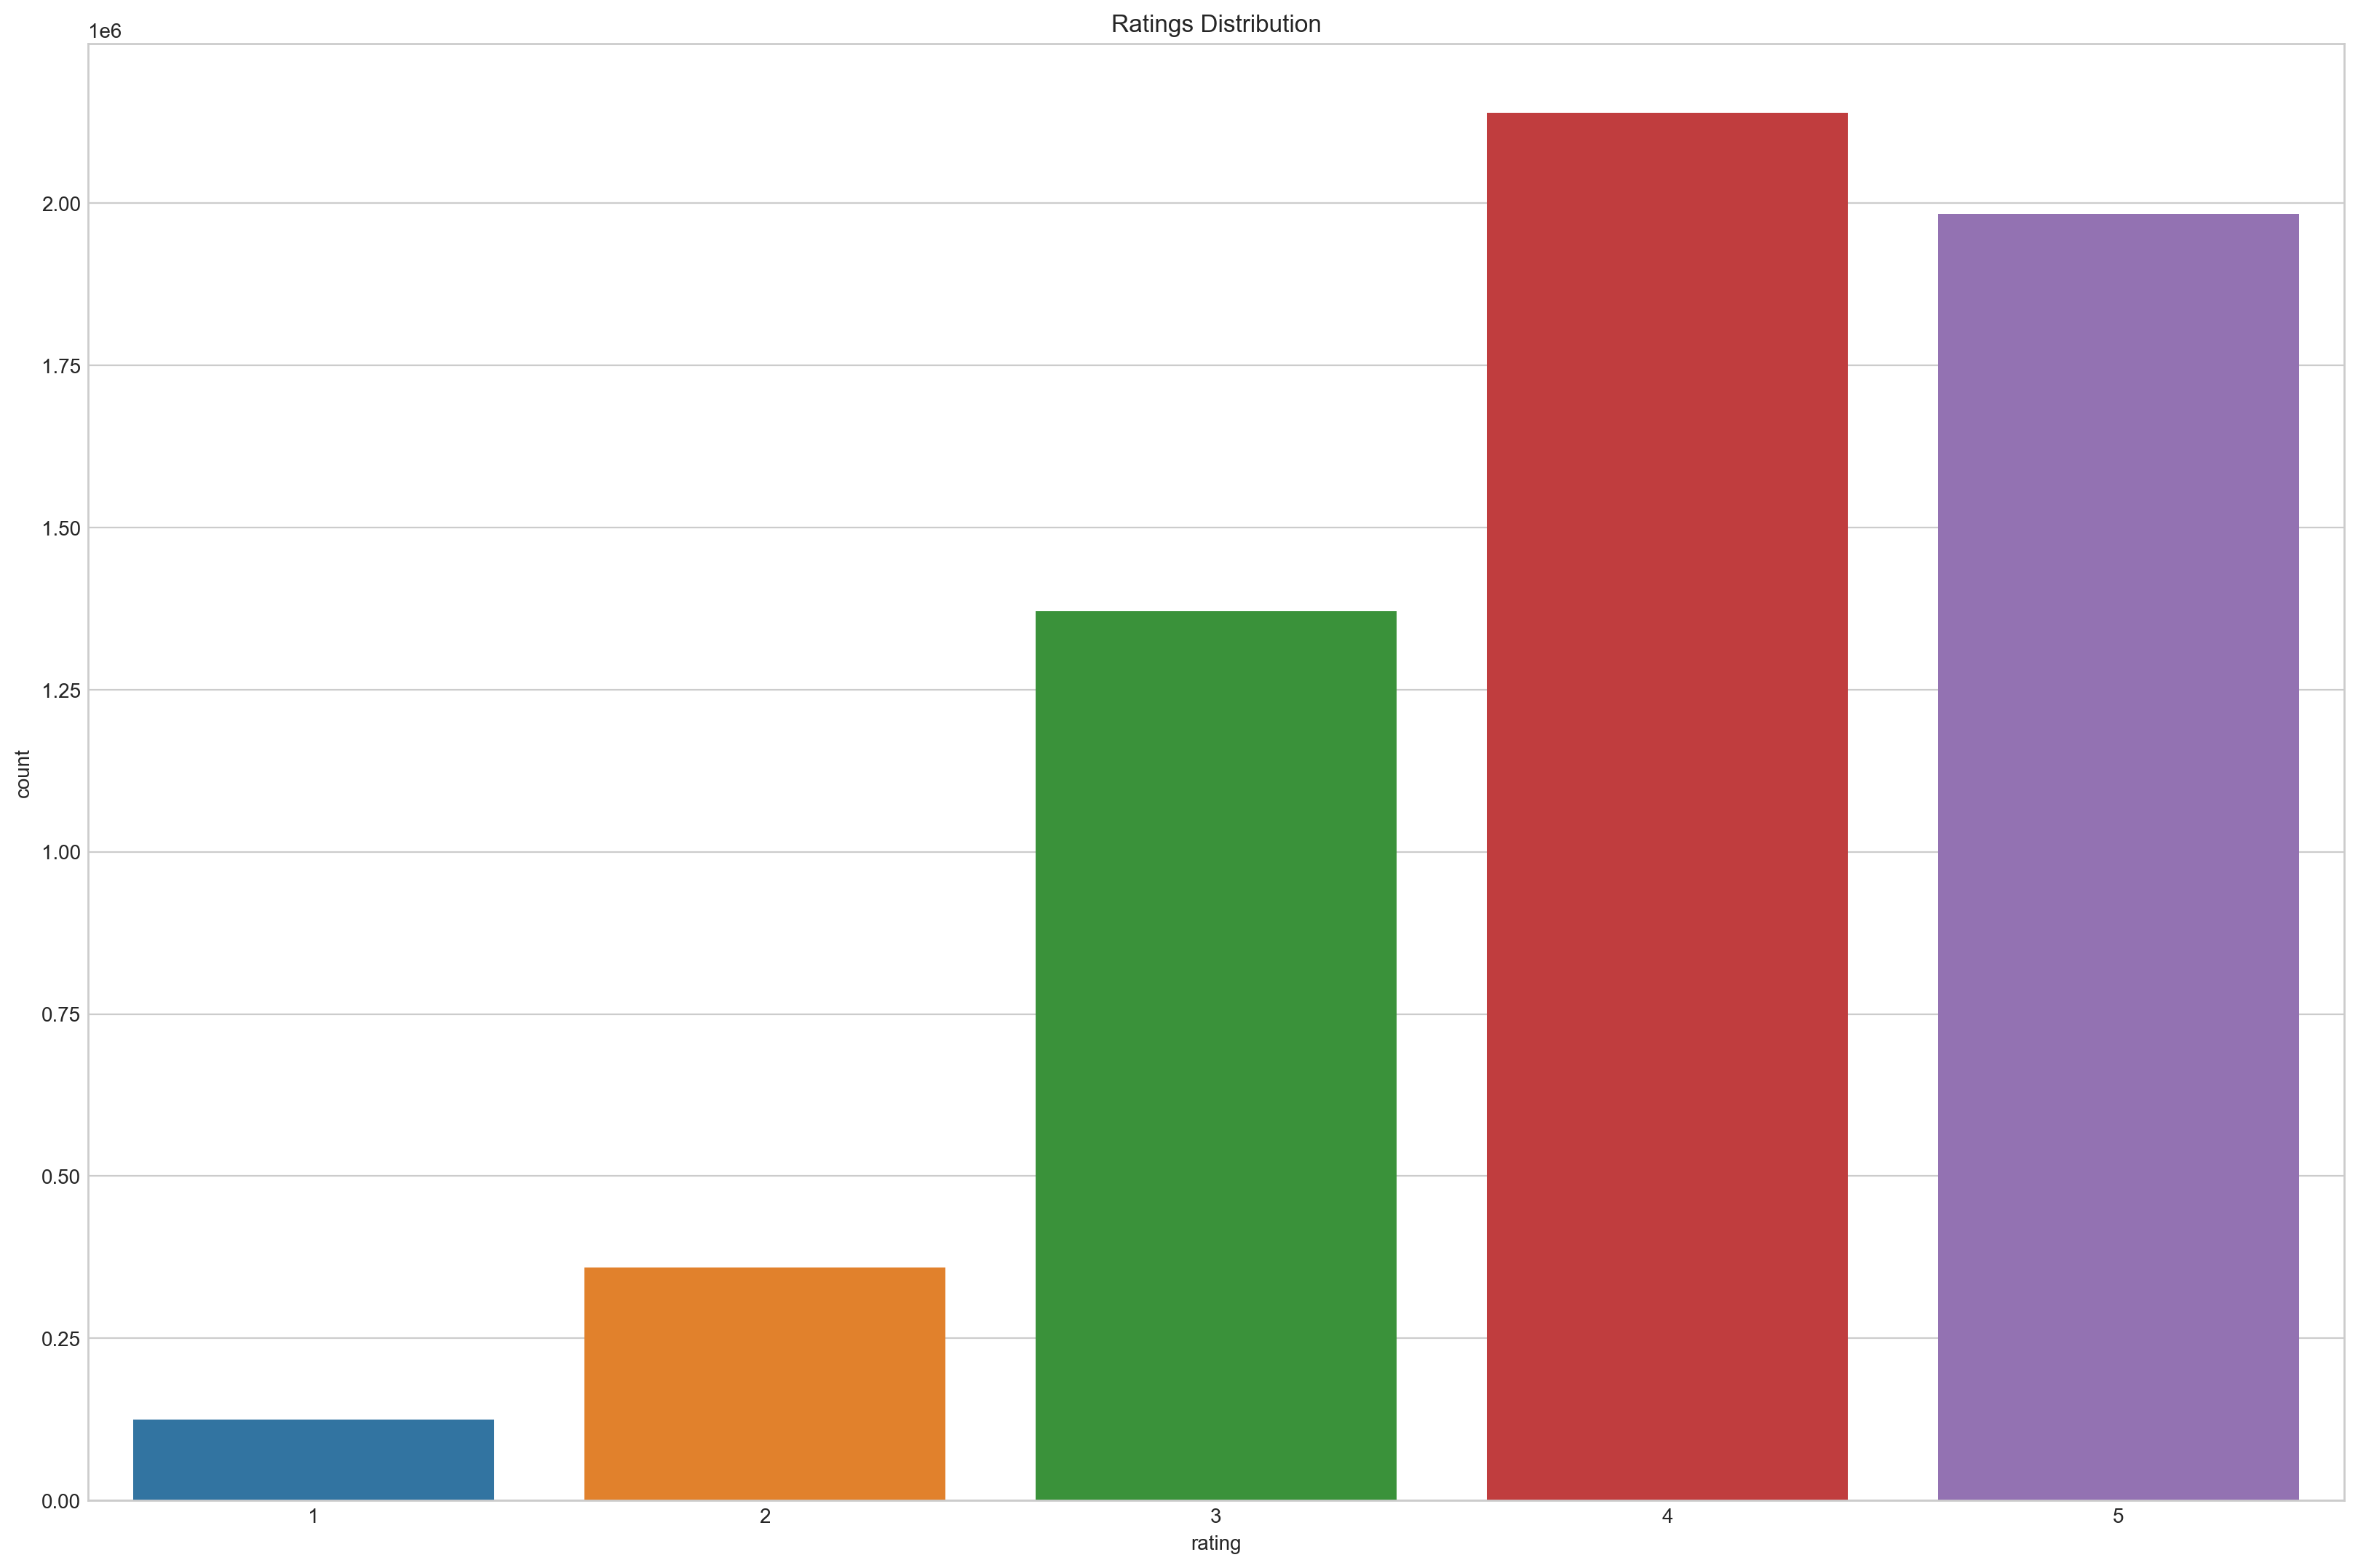

In [3]:
# Ratings distribution
sns.countplot(data=df_ratings, x="rating")
plt.title("Ratings Distribution")
plt.show()

We can already see how the ratings are mostly positive, with a few negative ratings, this means we need to be careful with the RMSE metric, as it can be biased towards positive ratings.

Let's have a look at possible long-tail effects in the number of ratings per book and per user.

In [4]:
# Rating frequency
book_rating_freq = pd.DataFrame(df_ratings.groupby("book_id").size(), columns=["count"])
book_rating_freq.head()

,count
book_id,
1,22806
2,21850
3,16931
4,19088
5,16604


/opt/homebrew/lib/python3.11/site-packages/seaborn/_core.py:1218: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which 

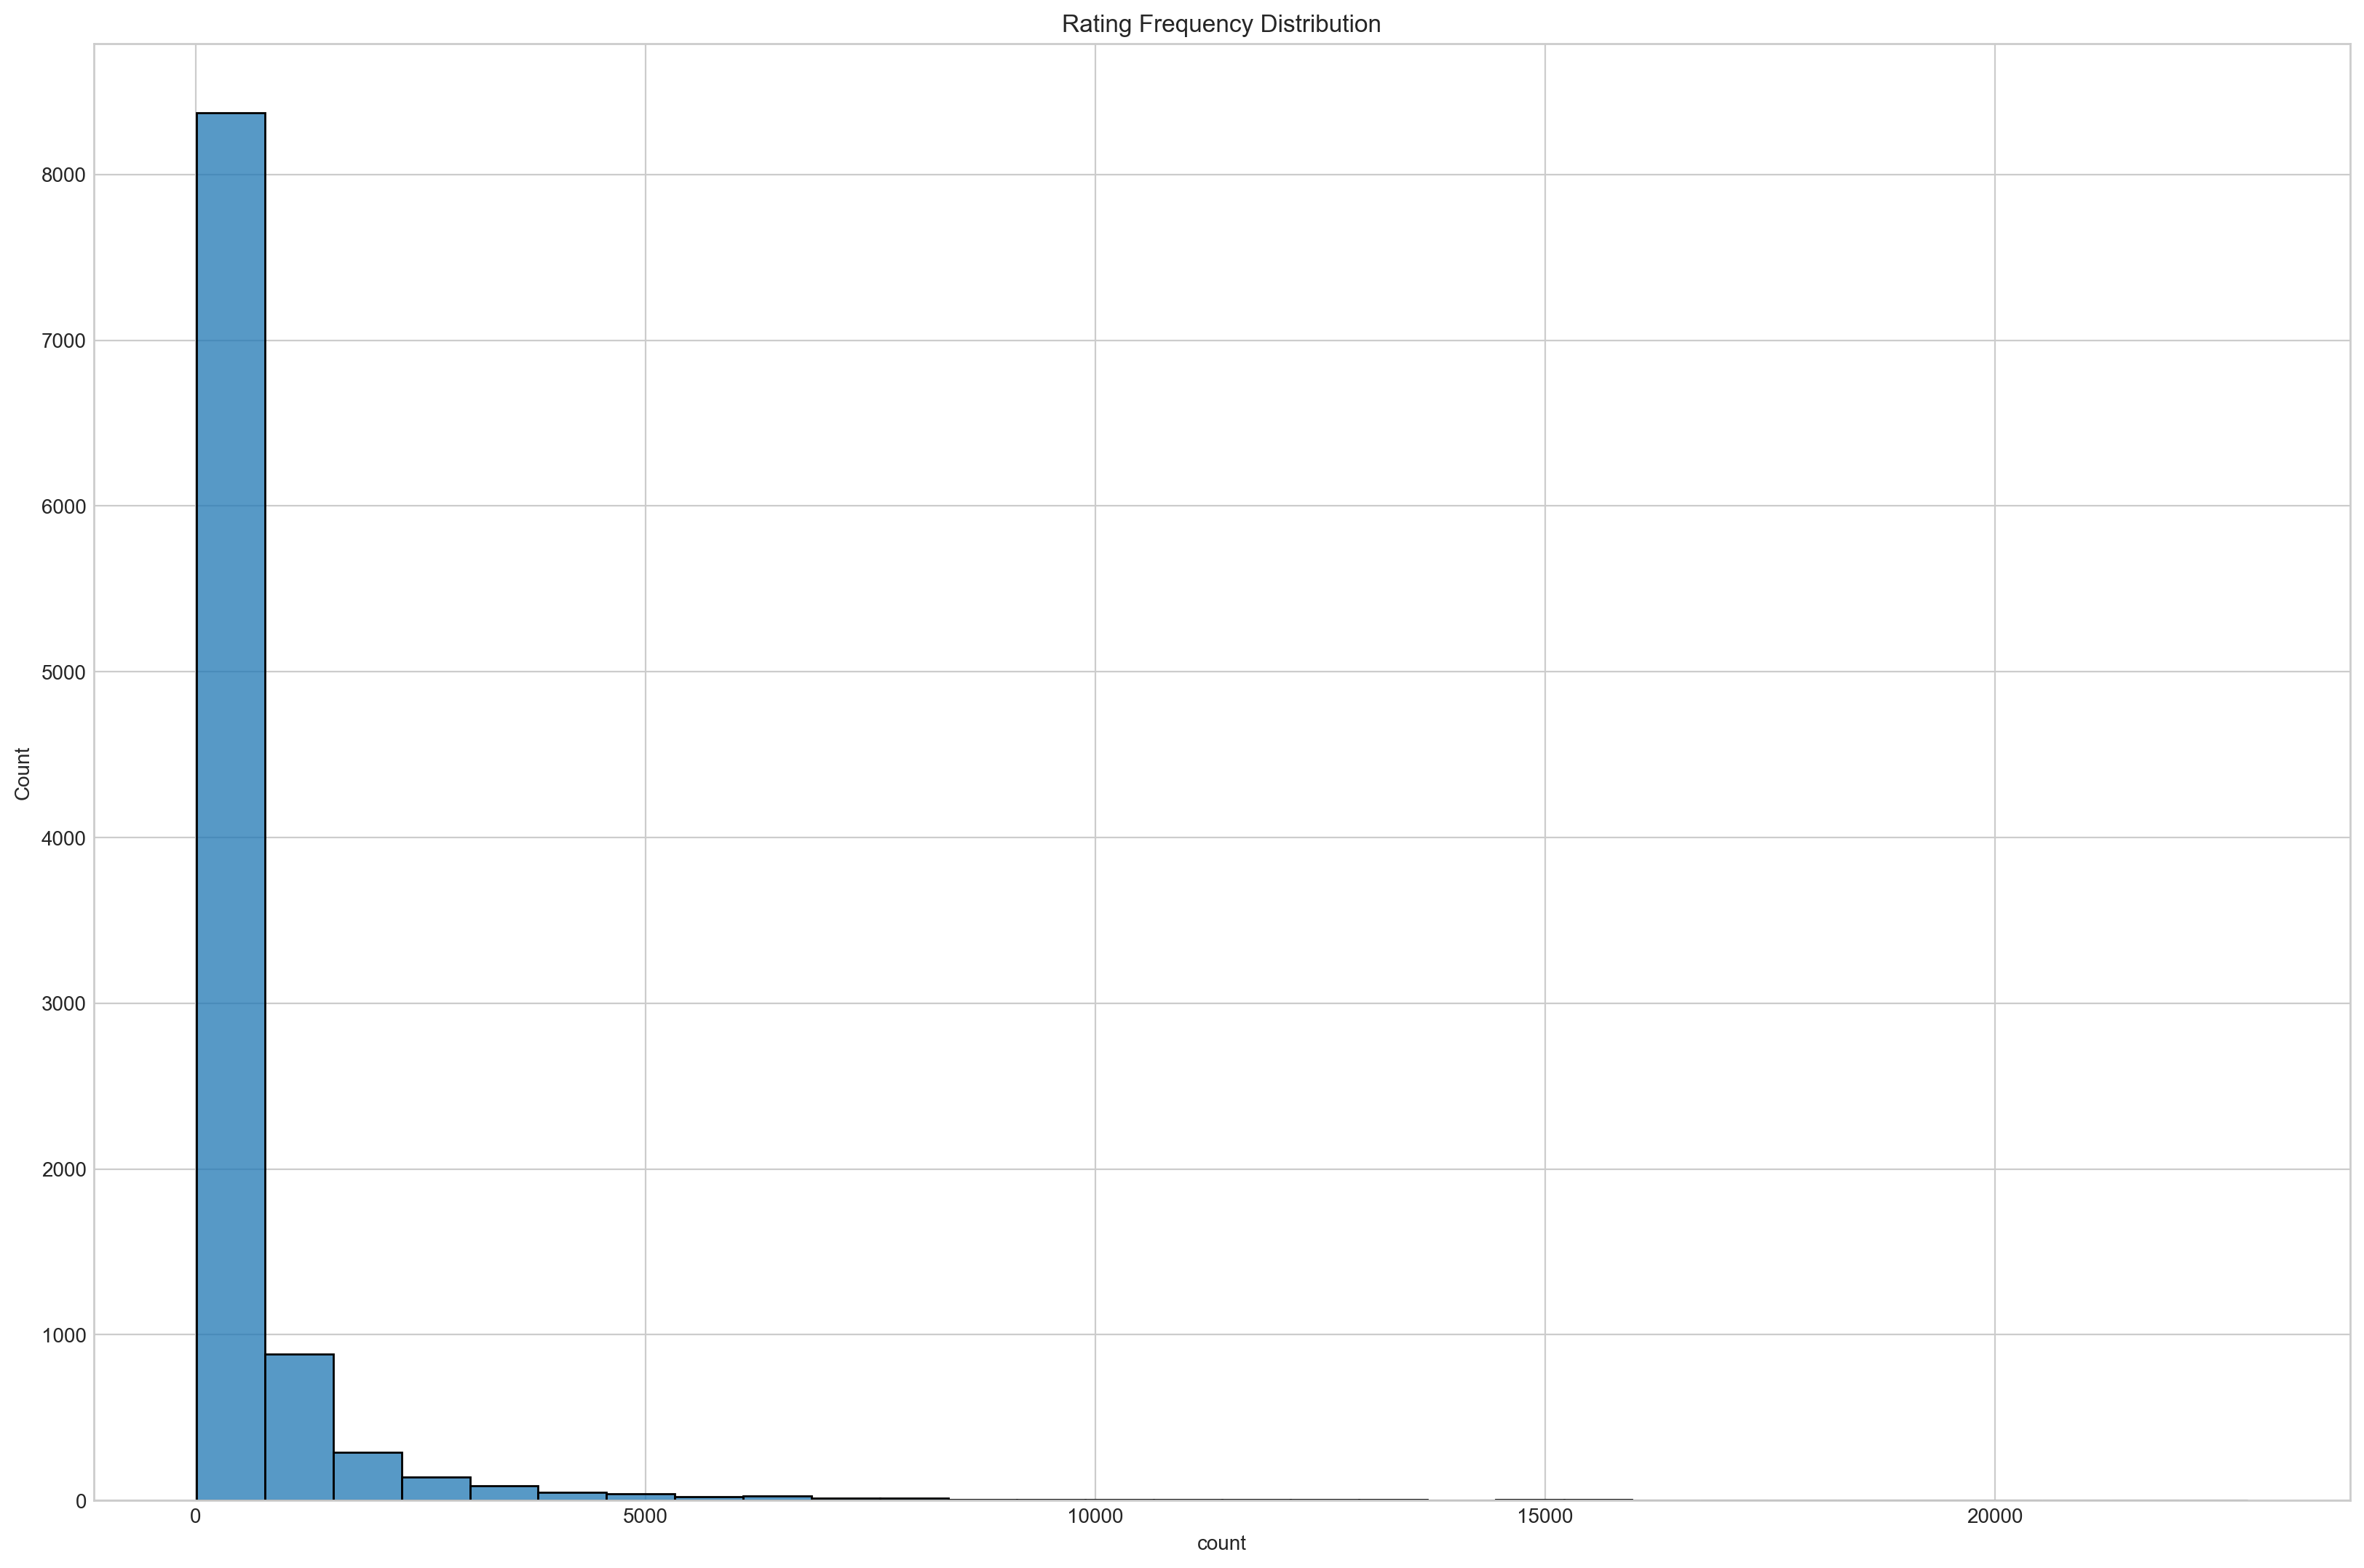

In [5]:
# Rating frequency distribution
sns.histplot(book_rating_freq, x="count", bins=30)
plt.title("Rating Frequency Distribution")
plt.show()

Text(0, 0.5, 'number of ratings')

/opt/homebrew/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpecte

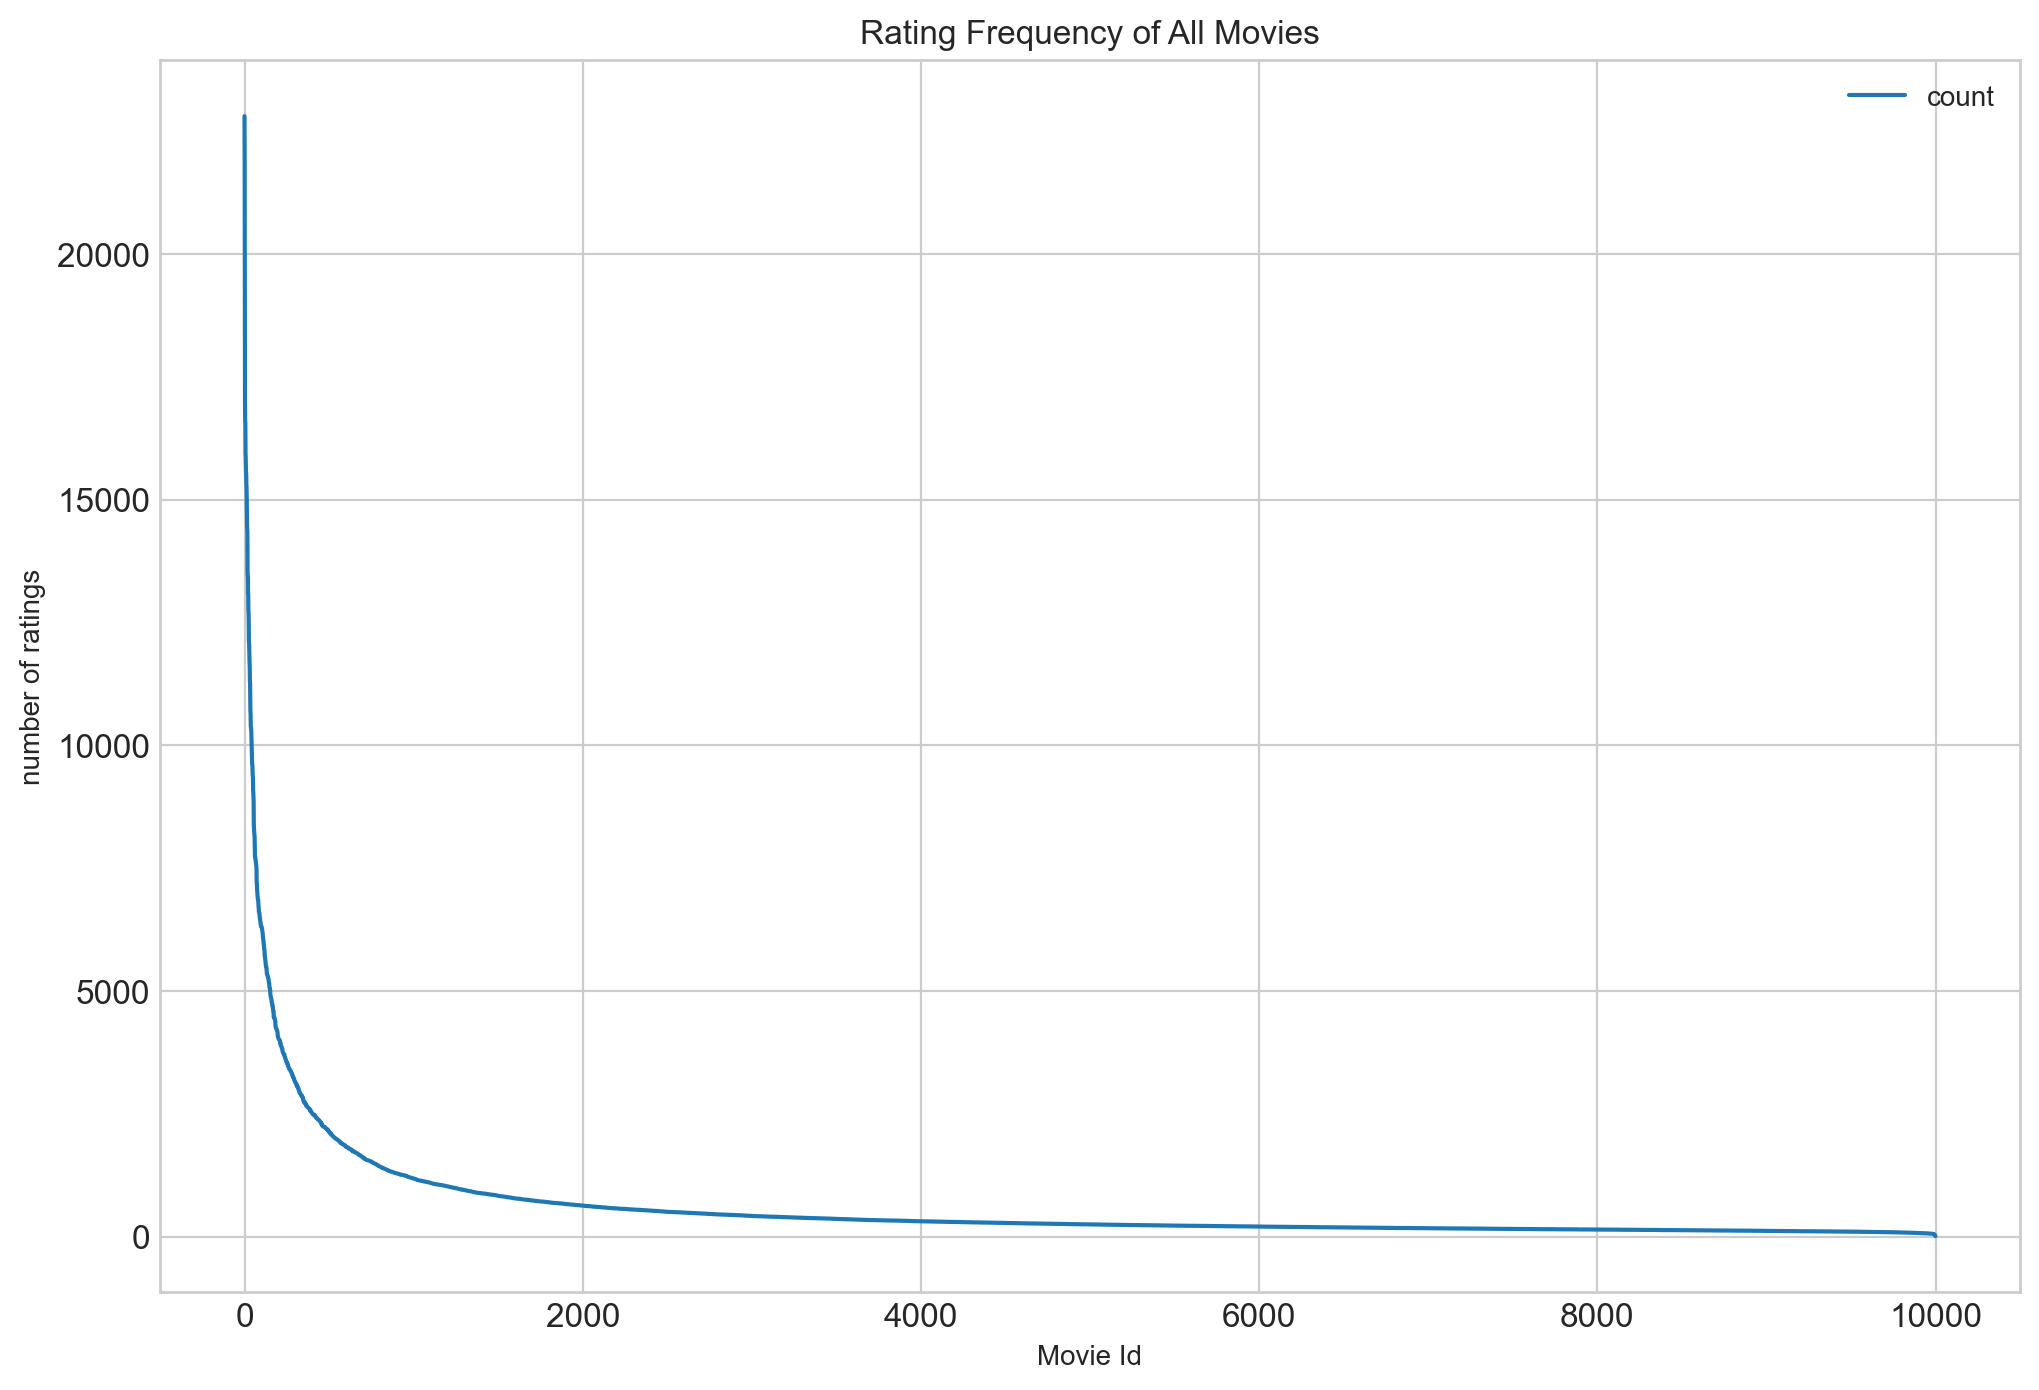

In [6]:
# plot rating frequency of all movies
ax = (
    book_rating_freq.sort_values("count", ascending=False)
    .reset_index(drop=True)
    .plot(figsize=(12, 8), title="Rating Frequency of All Movies", fontsize=12)
)
ax.set_xlabel("Movie Id")
ax.set_ylabel("number of ratings")

We can do the same per user to see if there are any users that have rated a lot of books.

In [7]:
user_rat_freq = pd.DataFrame(df_ratings.groupby("user_id").size(), columns=["count"])
user_rat_freq.head()

,count
user_id,
1,117
2,65
3,91
4,134
5,100


/opt/homebrew/lib/python3.11/site-packages/seaborn/_core.py:1218: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which 

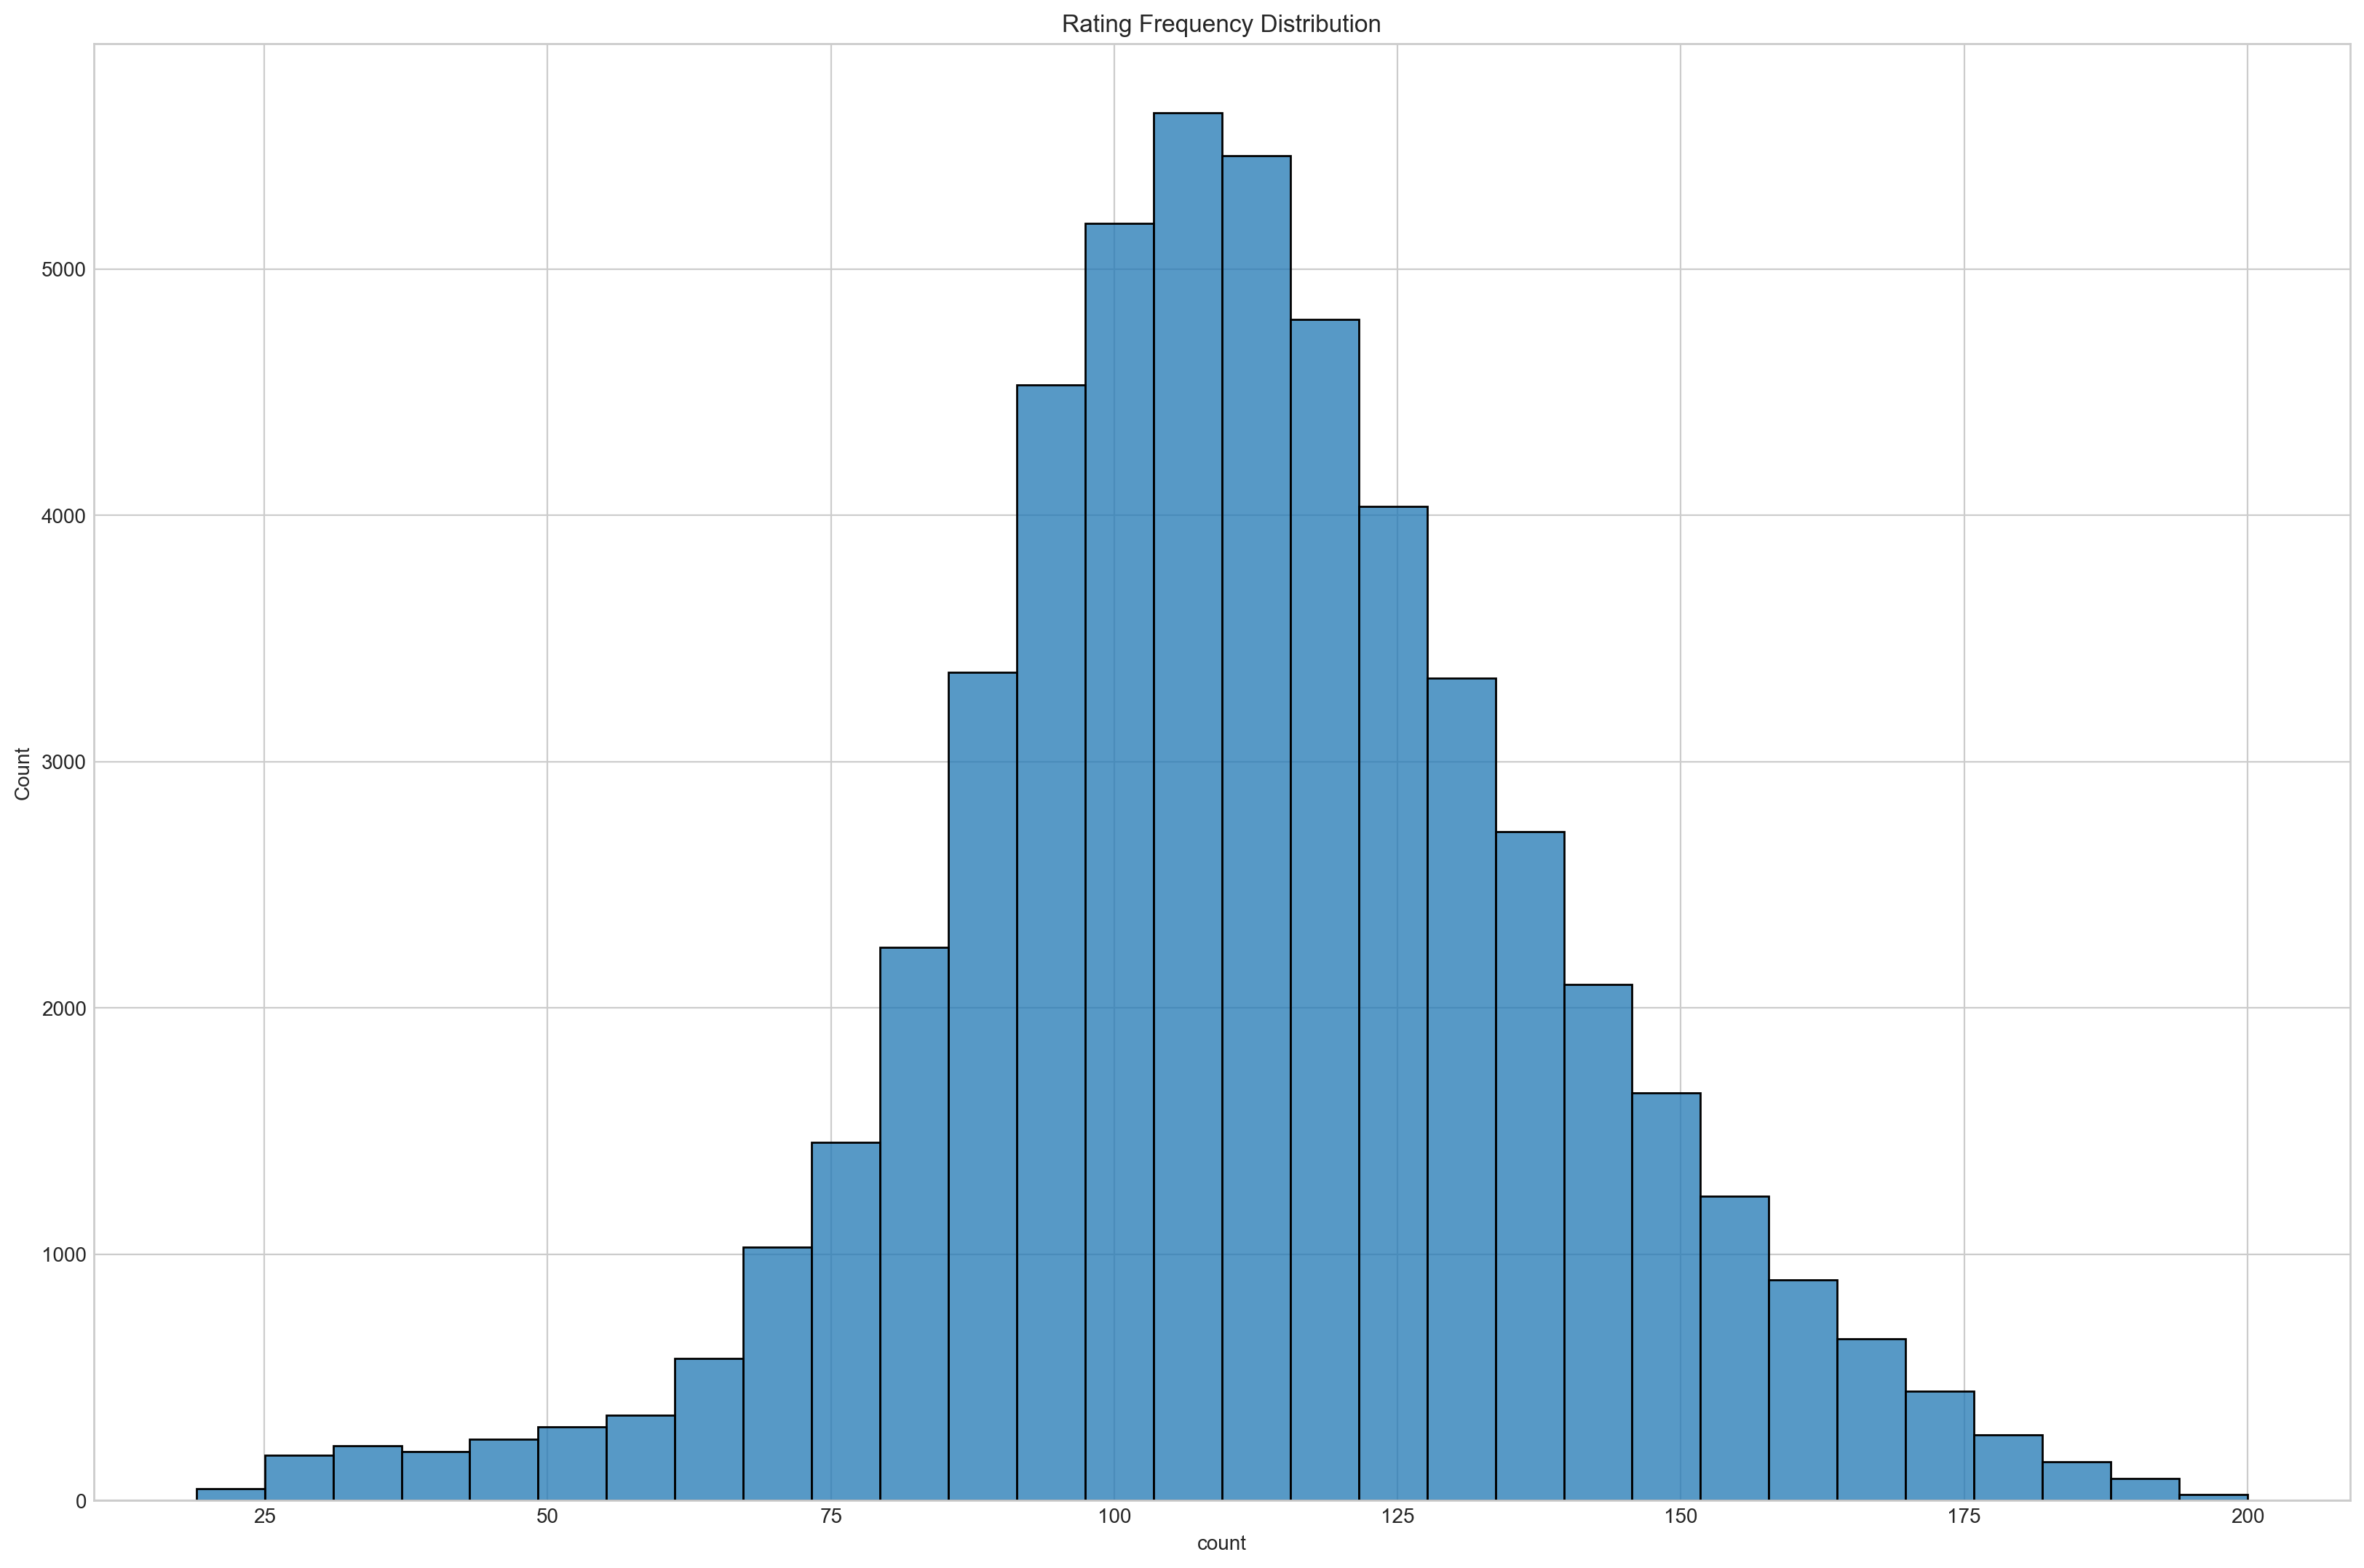

In [8]:
# Rating frequency distribution
sns.histplot(user_rat_freq, x="count", bins=30)
plt.title("Rating Frequency Distribution")
plt.show()

Text(0, 0.5, 'number of ratings')

/opt/homebrew/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpecte

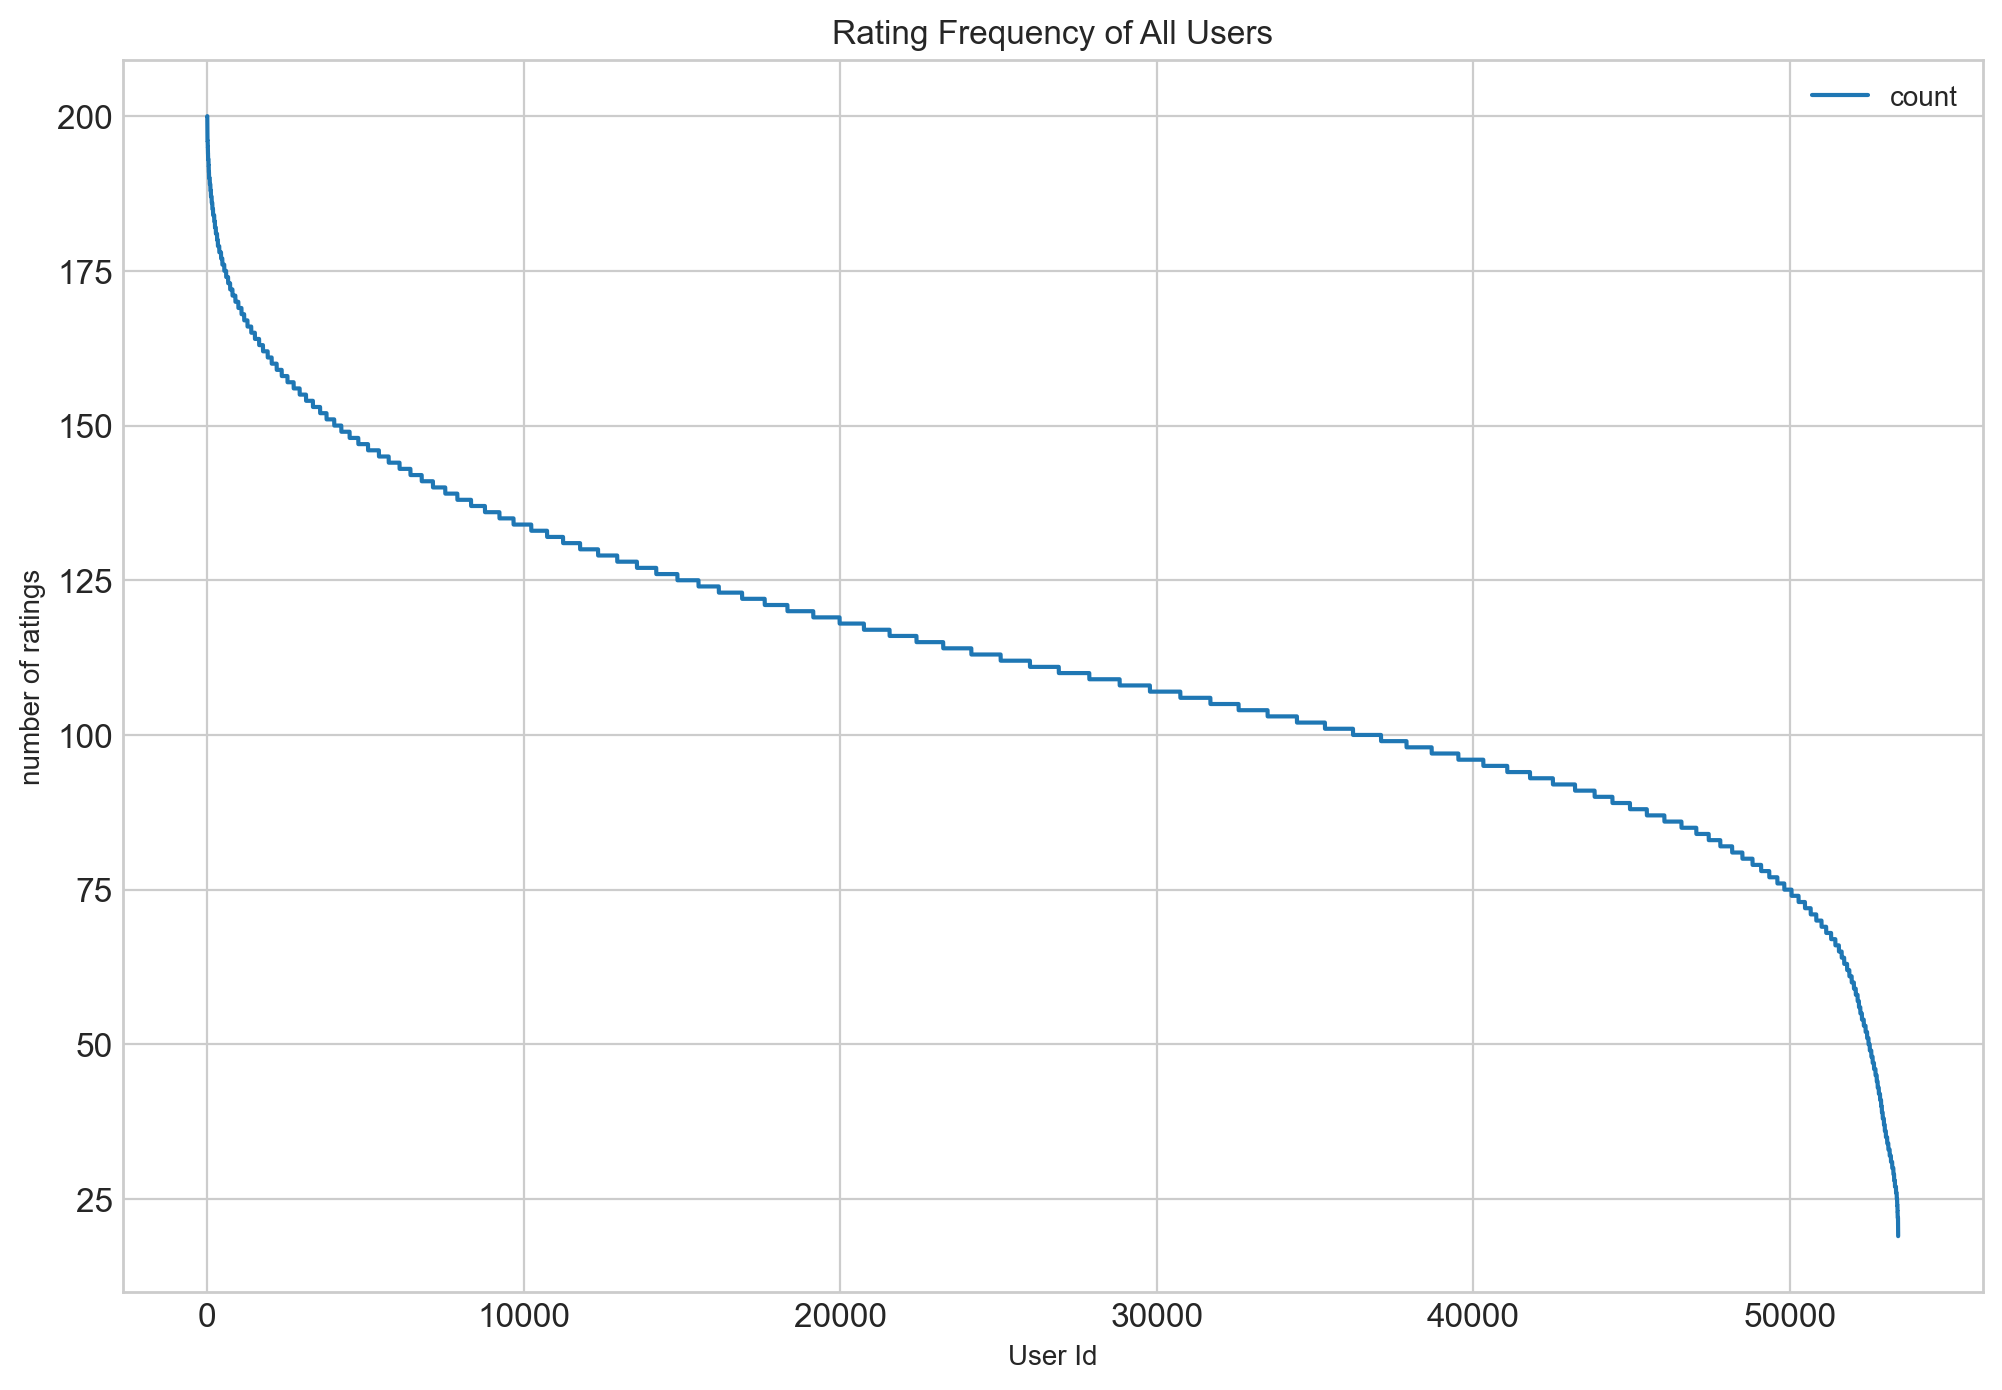

In [9]:
# plot rating frequency of all users
ax = (
    user_rat_freq.sort_values("count", ascending=False)
    .reset_index(drop=True)
    .plot(figsize=(12, 8), title="Rating Frequency of All Users", fontsize=12)
)
ax.set_xlabel("User Id")
ax.set_ylabel("number of ratings")

There is no long tail effect in the number of ratings per user, but there is one in the number of ratings per book.

To conclude the data analysis, we can transform the ratings dataframe in a sparse matrix, where the rows are the users, the columns are the books, and the values are the ratings.

In [10]:
df_matrix = df_ratings.pivot(index="user_id", columns="book_id", values="rating")

In [11]:
df_matrix

book_id,1,2,3,4,5,6,7,8,9,10,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,10000
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,5.0,NaN,NaN,5.0,NaN,NaN,4.0,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,5.0,NaN,4.0,4.0,NaN,4.0,4.0,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53420,4.0,5.0,3.0,NaN,2.0,NaN,NaN,NaN,4.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53421,4.0,5.0,NaN,5.0,4.0,NaN,4.0,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53422,4.0,5.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Feature Engineering

We need to create a popularity score for books based on the number of ratings.

Let's create a feature that represents the popularity of books based on the number of ratings, taking into account also the average rating.

This can be expressed by the relationship between the number of ratings and the average rating.

$$ \text{popularity} = \text{average rating} \times \text{number of ratings} $$

To do so we need to calculate the number of non-nan ratings per book. 
In pandas, we can achieve such a result by

```python
book_ratings_count = df_matrix.count(axis=0)
```

In [12]:
book_rating_count = df_matrix.count()
book_rating_count

book_id
1        22806
2        21850
3        16931
4        19088
5        16604
         ...  
9996       141
9997        93
9998       102
9999       130
10000      111
Length: 10000, dtype: int64

In [13]:
def popularity_score(book_id: int) -> float:
    """
    Calculate the popularity score of a book based on its ratings. We normalise by the maximum number of ratings.
    """
    book_ratings = df_ratings[df_ratings["book_id"] == book_id]
    return (
        book_ratings["rating"].mean()
        * book_rating_count[book_id]
        / book_rating_count.max()
    )

In [14]:
# Popularity score of book with id 1
popularity_score(1)

4.2797070946242215

## Model Building

We want to use a collaborative filtering model.

In [15]:
# Split the dataset into training and testing sets
df_train, df_test = train_test_split(df_ratings, test_size=0.2, random_state=42)

In [16]:
df_train.shape, df_test.shape

((4781183, 3), (1195296, 3))

In [17]:
df_matrix_train = df_train.pivot(index="user_id", columns="book_id", values="rating")
df_matrix_test = df_test.pivot(index="user_id", columns="book_id", values="rating")

Once the train_test_split is done, we can build the model.

We can use numpy to create the matrix factorization model.

In [18]:
def als(
    user_item_matrix: np.ndarray, num_features: int, lambda_: float, iterations: int
) -> tuple:
    """
    Perform matrix factorization using Alternating Least Squares (ALS).

    Parameters
    ----------
    user_item_matrix : np.ndarray
        User-item rating matrix with users as rows and items as columns.
    num_features : int
        Number of latent features.
    lambda_ : float
        Regularization parameter.
    iterations : int
        Number of iterations to run the algorithm.

    Returns
    -------
    tuple
        Tuple of user_features and item_features matrices.
    """
    num_users, num_items = user_item_matrix.shape
    user_features = np.random.normal(
        scale=1.0 / num_features, size=(num_users, num_features)
    )
    item_features = np.random.normal(
        scale=1.0 / num_features, size=(num_items, num_features)
    )

    # Create a mask of observed entries
    observed = ~np.isnan(user_item_matrix)
    user_item_matrix = np.nan_to_num(user_item_matrix)

    # Precompute Iλ (λ times the identity matrix of dimension k x k)
    Iλ = lambda_ * np.eye(num_features)

    for _ in range(iterations):
        # Update user features
        for i in range(num_users):
            Vj = item_features[observed[i], :]  # Filter to only items rated by user i
            YTY = np.dot(Vj.T, Vj)  # Vj.T * Vj
            user_features[i] = np.linalg.solve(
                YTY + Iλ, np.dot(Vj.T, user_item_matrix[i, observed[i]])
            )

        # Update item features
        for j in range(num_items):
            Ui = user_features[
                observed[:, j], :
            ]  # Filter to only users that rated item j
            UTU = np.dot(Ui.T, Ui)  # Ui.T * Ui
            item_features[j] = np.linalg.solve(
                UTU + Iλ, np.dot(Ui.T, user_item_matrix[observed[:, j], j])
            )

    return user_features, item_features


# Example usage:
Y = np.array(
    [
        [5, 3, np.nan, 1],
        [4, np.nan, np.nan, 1],
        [1, 1, np.nan, 5],
        [1, np.nan, np.nan, 4],
        [np.nan, 1, 5, 4],
    ]
)

user_features, item_features = als(Y, num_features=2, lambda_=0.1, iterations=20)
print("User Features:\n", user_features)
print("Item Features:\n", item_features)

User Features:
 [[-2.47531773 -0.38351963]
 [-1.95202539 -0.42169579]
 [-0.23100583 -2.87036589]
 [-0.28169436 -2.28797086]
 [-0.3521281  -2.39223786]]
Item Features:
 [[-1.97681285 -0.19239095]
 [-1.15394583 -0.25198882]
 [-0.29606538 -2.01136696]
 [-0.1414581  -1.69828865]]


Let's use the function above to generate recommendations for a set of users.

In [19]:
item_features, user_features = als(
    df_matrix_train.values, num_features=20, lambda_=0.1, iterations=10
)

item_features.shape, user_features.shape

((53424, 20), (10000, 20))

We can now give recommendations for a set of users, first we reconstruct the matrix, with missing values filled with the estimated rating, hence we look for the user index and we recommend the books with the highest estimated rating.

In [1]:
def generate_recommendations(
    user_features: np.ndarray,
    item_features: np.ndarray,
    user_item_matrix: np.ndarray,
    top_n: int = 5,
) -> dict:
    """
    Generate recommendations for each user.

    Parameters
    ----------
    user_features : np.ndarray
        Matrix containing the latent features for each user.
    item_features : np.ndarray
        Matrix containing the latent features for each item.
    user_item_matrix : np.ndarray
        Original matrix of users and items with missing values.
    top_n : int
        Number of recommendations to return for each user.

    Returns
    -------
    dict
        A dictionary where keys are user indices and values are lists of recommended item indices.
    """
    # Compute full matrix of predicted ratings
    predicted_ratings = np.dot(user_features, item_features.T)

    # Create a mask for already-rated items so they are not recommended
    already_rated = np.isfinite(user_item_matrix)
    # Exclude already rated items
    # predicted_ratings[already_rated] = -np.inf

    # Generate recommendations
    recommendations = {}
    for user_index in range(1, user_item_matrix.shape[0]):
        # Get top N item indices
        recommended_items = np.argsort(predicted_ratings[user_index - 1])[-top_n:][::-1]
        recommendations[user_index] = recommended_items.tolist()

    return recommendations


# Assuming you already have user_features and item_features from the ALS implementation
recommendations = generate_recommendations(
    user_features, item_features, df_matrix_train.values, top_n=5
)
print("Recommendations (user: [items]):", recommendations)

NameError: name 'np' is not defined

In [ ]:
# Calculate the root mean squared error of the predictions


def rmse(
    user_features: np.ndarray,
    item_features: np.ndarray,
    user_item_matrix: np.ndarray,
    observed_mask: np.ndarray,
) -> float:
    """
    Calculate the root mean squared error of the predictions.

    Parameters
    ----------
    user_features : np.ndarray
        Matrix containing the latent features for each user.
    item_features : np.ndarray
        Matrix containing the latent features for each item.
    user_item_matrix : np.ndarray
        Original matrix of users and items with missing values.
    observed_mask : np.ndarray
        Mask of observed entries in the user-item matrix.

    Returns
    -------
    float
        Root mean squared error of the predictions.
    """
    predicted_ratings = np.dot(user_features, item_features.T)
    return np.sqrt(
        np.sum((predicted_ratings - user_item_matrix) ** 2) / np.sum(observed_mask)
    )